## Modeling for predicting critical outcome at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0,32,36,31


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.07053365376014503 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 6.812549829483032 seconds
AUC: 0.844736277266634
AUPRC: 0.31885932643670034
Sensitivity: 0.7761470985155196
Specificity: 0.7382264529058116
Score thresold: 0.06100101295562771
2.5 97.5


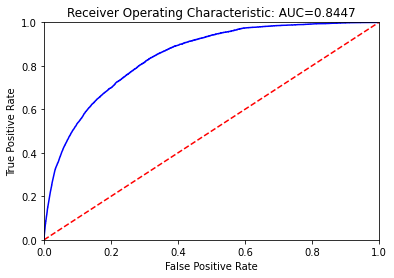

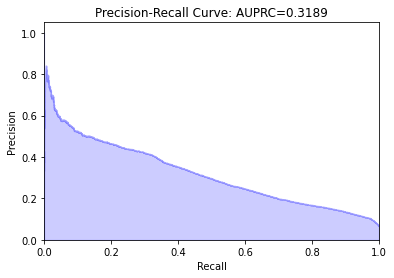

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 835.1534969806671 seconds
AUC: 0.8855916388638082
AUPRC: 0.4040449674752022
Sensitivity: 0.8286099865047234
Specificity: 0.7852013550911346
Score thresold: 0.04616295982293933
2.5 97.5


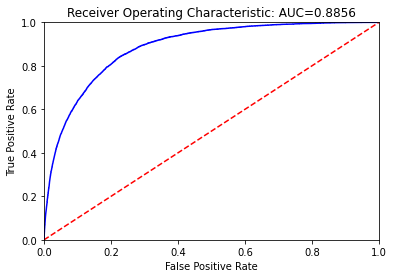

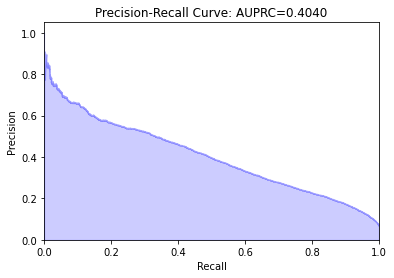

In [12]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 76.86459755897522 seconds
AUC: 0.8865400314960619
AUPRC: 0.42025284676586194
Sensitivity: 0.8063427800269906
Specificity: 0.8090705219963736
Score thresold: 0.08333333333333331
2.5 97.5


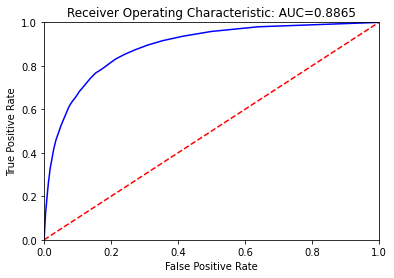

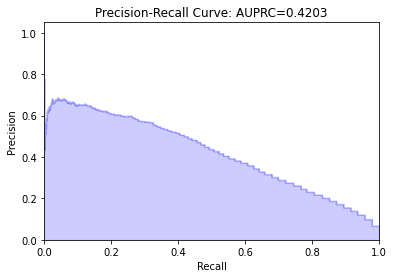

[0.10096141 0.01437063 0.00647343 0.0102035  0.01907873 0.00628869
 0.00980763 0.01670357 0.00289023 0.00676276 0.01153223 0.07601708
 0.09395872 0.05508146 0.06714609 0.09581539 0.08062425 0.046145
 0.08220532 0.00572003 0.00611371 0.00359725 0.00151561 0.0022015
 0.00225874 0.00275504 0.00455465 0.00325585 0.00289333 0.00507826
 0.00561883 0.00507288 0.00509363 0.00284121 0.00727214 0.00264332
 0.00270026 0.00461499 0.00726285 0.00468536 0.00240204 0.00489335
 0.00531135 0.00282649 0.00374723 0.00108968 0.00723953 0.00459432
 0.00445232 0.00484405 0.00879753 0.00586208 0.00543224 0.00172173
 0.00539987 0.00539999 0.00452594 0.00696524 0.00218696 0.00436691
 0.00485215 0.00380399 0.00261665 0.00685283]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 93.07080793380737 seconds
AUC: 0.8936033395593963
AUPRC: 0.43720159988541024
Sensitivity: 0.8242240215924427
Specificity: 0.8042275026242962
Score thresold: 0.07080459175735267
2.5 97.5


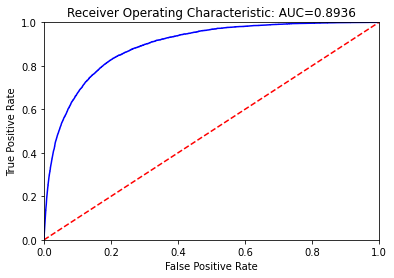

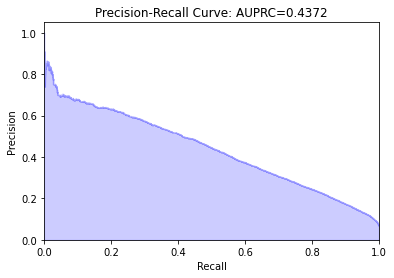

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [16]:
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.789784020478139
AUPRC: 0.1944936375006208
Sensitivity: 0.8959176788124157
Specificity: 0.6333142475427045
Score thresold: -2.6248987751080204
49.525 50.475


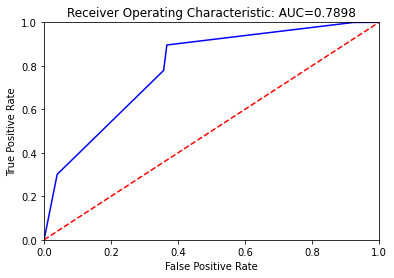

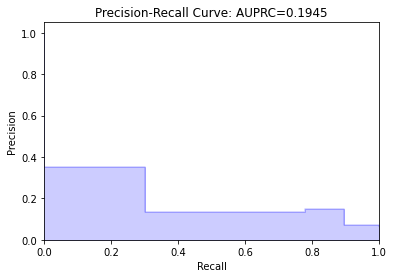

In [17]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI")

score_NEWS
AUC: 0.6002591746052351
AUPRC: 0.1525796637565012
Sensitivity: 0.4144736842105263
Specificity: 0.7993129115373605
Score thresold: 2
49.525 50.475


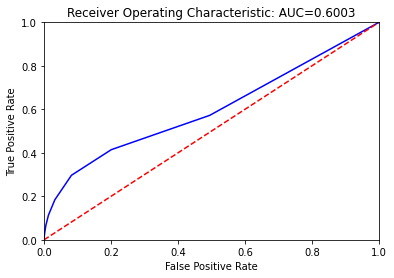

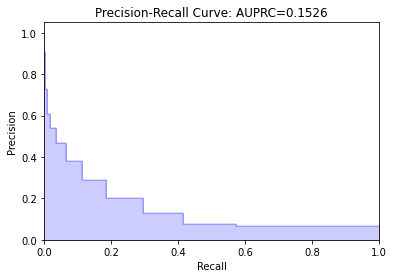

In [18]:
get_score_performance("score_NEWS")

score_NEWS2
AUC: 0.587080282037631
AUPRC: 0.13968412809478523
Sensitivity: 0.37449392712550605
Specificity: 0.8263789483729364
Score thresold: 2
49.525 50.475


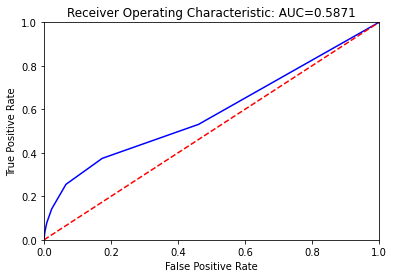

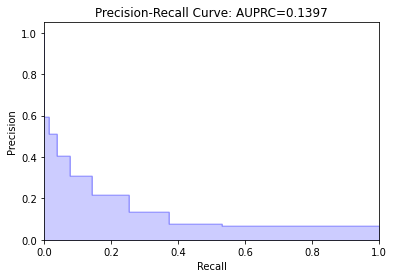

In [19]:
get_score_performance("score_NEWS2")

score_REMS
AUC: 0.6638998005167845
AUPRC: 0.11202249052255793
Sensitivity: 0.645748987854251
Specificity: 0.6163517511212901
Score thresold: 5
49.525 50.475


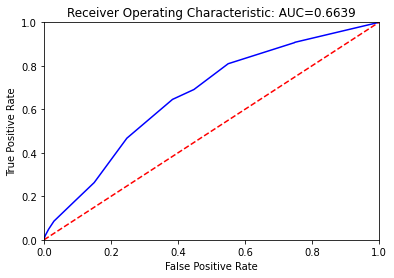

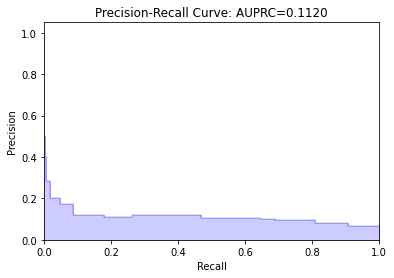

In [20]:
get_score_performance("score_REMS")

score_MEWS
AUC: 0.6056137210559542
AUPRC: 0.11437508107058239
Sensitivity: 0.40468960863697706
Specificity: 0.7761356045424181
Score thresold: 2
49.525 50.475


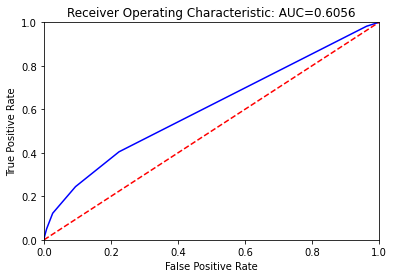

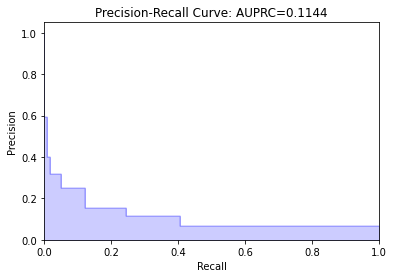

In [21]:
get_score_performance("score_MEWS")

score_CART
AUC: 0.6923679410907155
AUPRC: 0.15759081132763783
Sensitivity: 0.5588731443994602
Specificity: 0.7325603588128637
Score thresold: 6
49.525 50.475


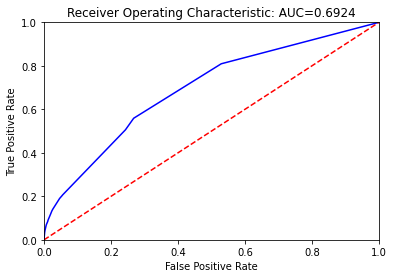

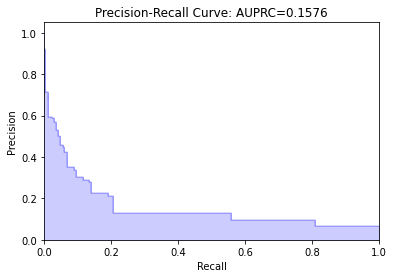

In [22]:
get_score_performance("score_CART")

### 4. Performance output

In [23]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.844736,0.318859,0.776147,0.738226,0.061001,0.840184,0.849135,0.002318,0.305872,0.332668,0.006442,0.751387,0.795489,0.011445,0.720080,0.761731,0.010315,6.812550
1,MLP,0.885592,0.404045,0.828610,0.785201,0.046163,0.881659,0.889532,0.001991,0.389079,0.417858,0.006826,0.813302,0.842239,0.007489,0.777180,0.800596,0.006249,835.153497
2,RF,0.886540,0.420253,0.806343,0.809071,0.083333,0.882881,0.891530,0.002042,0.408027,0.435633,0.007279,0.801116,0.836698,0.012407,0.785358,0.811863,0.011658,76.864598
3,GB,0.893603,0.437202,0.824224,0.804228,0.070805,0.890284,0.897270,0.001749,0.422698,0.451551,0.006736,0.806185,0.834945,0.007383,0.797653,0.821505,0.006608,93.070808
4,ESI,0.789784,0.194494,0.895918,0.633314,-2.624899,0.789912,0.789965,0.002335,0.194827,0.194910,0.003698,0.896064,0.896105,0.003491,0.633390,0.633413,0.001524,0.000000
5,score_NEWS,0.600259,0.152580,0.414474,0.799313,2.000000,0.600844,0.600898,0.004409,0.153051,0.153321,0.004548,0.414678,0.414842,0.006708,0.799474,0.799519,0.001283,0.000000
6,score_NEWS2,0.587080,0.139684,0.374494,0.826379,2.000000,0.587705,0.587814,0.004316,0.140265,0.140434,0.004174,0.375461,0.375571,0.027805,0.826467,0.826496,0.048863,0.000000
7,score_REMS,0.663900,0.112022,0.645749,0.616352,5.000000,0.663746,0.663866,0.003418,0.112384,0.112420,0.002395,0.645509,0.645689,0.006182,0.616306,0.616369,0.001709,0.000000
8,score_MEWS,0.605614,0.114375,0.404690,0.776136,2.000000,0.606131,0.606210,0.003636,0.115234,0.115276,0.003096,0.406120,0.406410,0.006487,0.776372,0.776401,0.001429,0.000000
9,score_CART,0.692368,0.157591,0.558873,0.732560,6.000000,0.692195,0.692279,0.003499,0.158144,0.158284,0.004307,0.559060,0.559082,0.006098,0.732689,0.732756,0.001515,0.000000


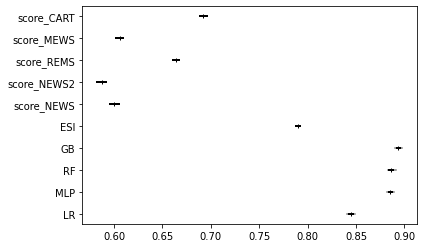

In [24]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval)

In [25]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.100961
15,triage_sbp,0.095815
12,triage_heartrate,0.093959
18,triage_acuity,0.082205
16,triage_dbp,0.080624
11,triage_temperature,0.076017
14,triage_o2sat,0.067146
13,triage_resprate,0.055081
17,triage_pain,0.046145
4,n_ed_365d,0.019079
